# Validation of `NPE` against `sbi` 

In [10]:
%load_ext autoreload

%autoreload 2

import os
import logging
import warnings

warnings.filterwarnings("ignore")
logging.getLogger('absl').setLevel("WARNING")

from typing import Callable, Any

import numpy as np


import jax
import jax.numpy as jnp

import torch
import torch.utils.data as data

import sbibm
from sbi.inference import NPE, SNLE
from sbi.utils import BoxUniform

import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS

import matplotlib.pyplot as plt

from tqdm import tqdm
from functools import partial

from getdist import MCSamples, plots

from jaxili.utils import create_data_loader
from jaxili.inference import NPE as NPE_JAX

import jax_dataloader as jdl

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
jax.devices()

[cuda(id=0)]

In [3]:
master_key = jax.random.PRNGKey(0)

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [5]:
%matplotlib inline

In [6]:
sbibm.get_available_tasks()

['gaussian_mixture',
 'bernoulli_glm',
 'gaussian_linear',
 'gaussian_linear_uniform',
 'slcp',
 'two_moons',
 'sir',
 'lotka_volterra',
 'slcp_distractors',
 'bernoulli_glm_raw']

## 1. Gaussian Linear Uniform

- Prior: $\mathcal{U}(-1, 1)$
- Simulator: $x|\theta \sim \mathcal{N}(x|m_\theta=\theta, S=0.1 \odot I)$
- $\theta \in \mathbb{R}^{10}, x \in \mathbb{R}^{10}$

In [7]:
task = sbibm.get_task('gaussian_linear_uniform')
prior = task.get_prior()
simulator = task.get_simulator()
reference_samples = jnp.array(task.get_reference_posterior_samples(num_observation=1))
observation = jnp.array(task.get_observation(num_observation=1))
truth = jnp.array(task.get_true_parameters(num_observation=1).flatten())

dim_theta = truth.shape[0]
dim_obs = observation.shape[1]

In [8]:
class SimulationDataset(data.Dataset):
    def __init__(self, simulator, prior, num_samples):
        super().__init__()
        self.theta = prior(num_samples=num_samples)
        self.x = simulator(self.theta)
        self.theta, self.x = np.array(self.theta, dtype=np.float32), np.array(self.x, dtype=np.float32)

    def __len__(self):
        return len(self.theta)

    def __getitem__(self, index):
        return self.theta[index], self.x[index]

In [11]:
train_set = SimulationDataset(simulator, prior, 20000)
val_set = SimulationDataset(simulator, prior, 5000)
test_set = SimulationDataset(simulator, prior, 5000)

train_loader, val_loader, test_loader = create_data_loader(
    train_set, val_set, test_set,
    train=[True, False, False],
    batch_size = 128
)

train_set_jax = jdl.ArrayDataset(train_set.theta, train_set.x)
val_set_jax = jdl.ArrayDataset(val_set.theta, val_set.x)
test_set_jax = jdl.ArrayDataset(test_set.theta, test_set.x)

train_loader_jax = jdl.DataLoader(train_set_jax, backend='jax', batch_size=128, shuffle=True, drop_last=True)
val_loader_jax = jdl.DataLoader(val_set_jax, backend='jax', batch_size=128, shuffle=False, drop_last=False)
test_loader_jax = jdl.DataLoader(test_set_jax, backend='jax', batch_size=128, shuffle=False, drop_last=False)

### Let's first use Neural Posterior Estimation

### Using `sbi` library

In [12]:
prior_inf = BoxUniform(low = -torch.ones(10), high=torch.ones(10), device=device)

In [13]:
#Create the inference object
inference = NPE(prior=prior_inf, device=device)
theta, sim = train_set[:]
theta, sim = torch.tensor(theta, dtype=torch.float32).to(device), torch.tensor(sim, dtype=torch.float32).to(device)

In [14]:
#Train !!!
inference = inference.append_simulations(theta, sim)
density_estimator = inference.train()

 Neural network successfully converged after 85 epochs.

In [15]:
posterior = inference.build_posterior()
print(posterior)

Posterior p(θ|x) of type DirectPosterior. It samples the posterior network and rejects samples that
            lie outside of the prior bounds.


In [16]:
x_obs = torch.from_numpy(np.array(observation)).to(device)

In [17]:
sbi_samples = posterior.sample((10_000,), x=x_obs)

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in
Removed no burn in


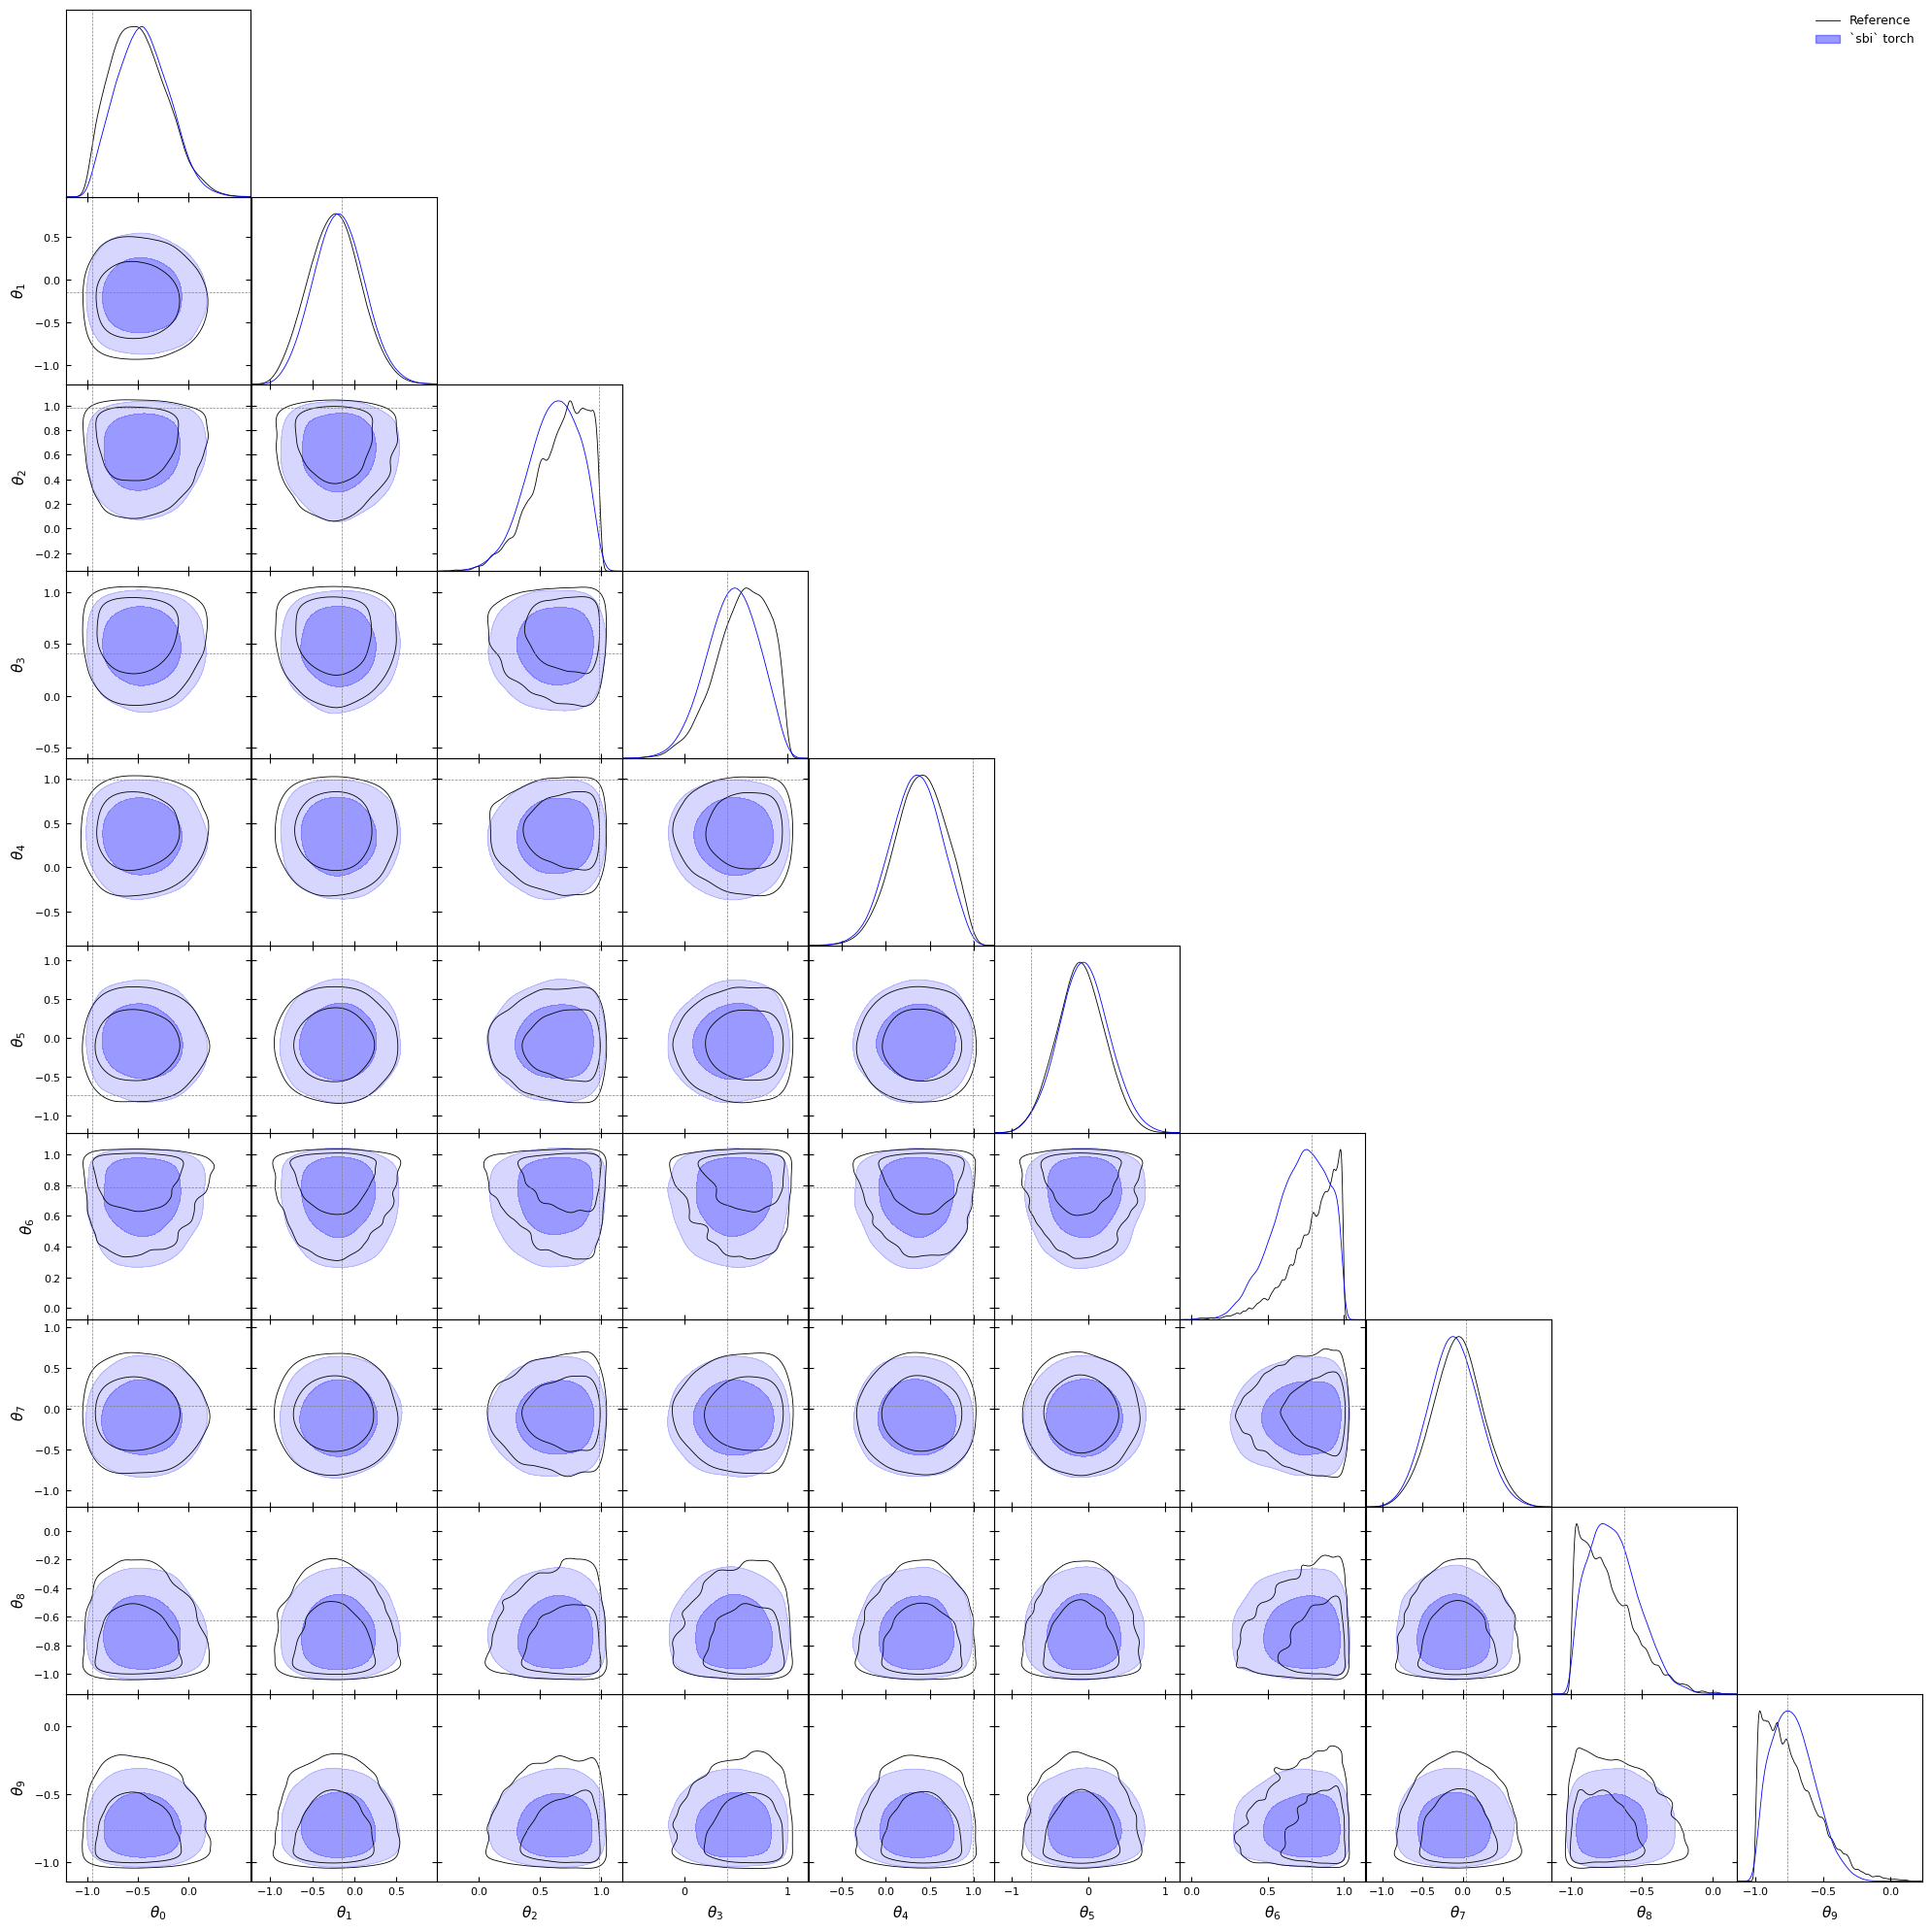

In [18]:
labels = [rf'\theta_{i}' for i in range(10)]

reference_samples_gd = MCSamples(samples=reference_samples, names=labels,
                                 labels=labels)

sbi_samples_gd = MCSamples(samples=sbi_samples.to('cpu').detach().numpy(), names=labels, labels=labels)

g = plots.get_subplot_plotter()

g.settings.figure_legend_frame = False
g.settings.alpha_filled_add = 0.4

g.triangle_plot([reference_samples_gd, sbi_samples_gd],
                filled=[False, True],
                legend_labels=["Reference", "`sbi` torch"],
                legend_loc="upper right",
                line_args=[
                    {'color': 'black'},
                    {'color': 'blue'}
                ],
                contour_colors=['black', 'blue'],
                markers={
                    label: val for label, val in zip(labels, truth) 
                }
               )

plt.show()

## Using `JaxILI` class `NPE`

In [19]:
learning_rate = 5e-4
batch_size = 128
checkpoint_path = "./checkpoints_GL_npe/"
checkpoint_path = os.path.abspath(checkpoint_path)

inference = NPE_JAX()

inference.set_dataset(train_set, type="train")
inference.set_dataset(val_set, type="val")
inference.set_dataset(test_set, type="test")

inference._dim_params = dim_theta
inference._dim_cond = dim_obs
inference._num_sims = len(train_set) + len(val_set) + len(test_set)

_, density_estimator = inference.train(
    training_batch_size=batch_size,
    learning_rate=learning_rate,
    checkpoint_path=checkpoint_path
)

posterior = inference.build_posterior()

[!] Creating DataLoaders with batch_size 128.
[!] Building the neural network.


Missing logger folder: /home/sacha/Documents/jaxili/notebooks/checkpoints_GL_npe/NDE_w_Standardization/


[!] Creating the Trainer module.
Could not tabulate model: 


[!] Training the density estimator.


Epochs: Val loss 0.634/ Best val loss 0.612:   0%|          | 66/2147483647 [01:12<655316:29:38,  1.10s/it]

Neural network training stopped after 67 epochs.
Early stopping with best validation metric: 0.6118396520614624
Best model saved at epoch 46
Early stopping parameters: min_delta=0.001, patience=20


[!] Training loss: 0.535781979560852
[!] Validation loss: 0.6118396520614624
[!] Test loss: 0.7002558708190918
[!] Posterior $p(\theta| x)$ built. The class DirectPosterior is used to sample and evaluate the log probability.


In [20]:
key, master_key = jax.random.split(master_key)
samples_maf_npe = posterior.sample(
    x=observation, num_samples=10000, key=key
)

Removed no burn in
Removed no burn in
Removed no burn in


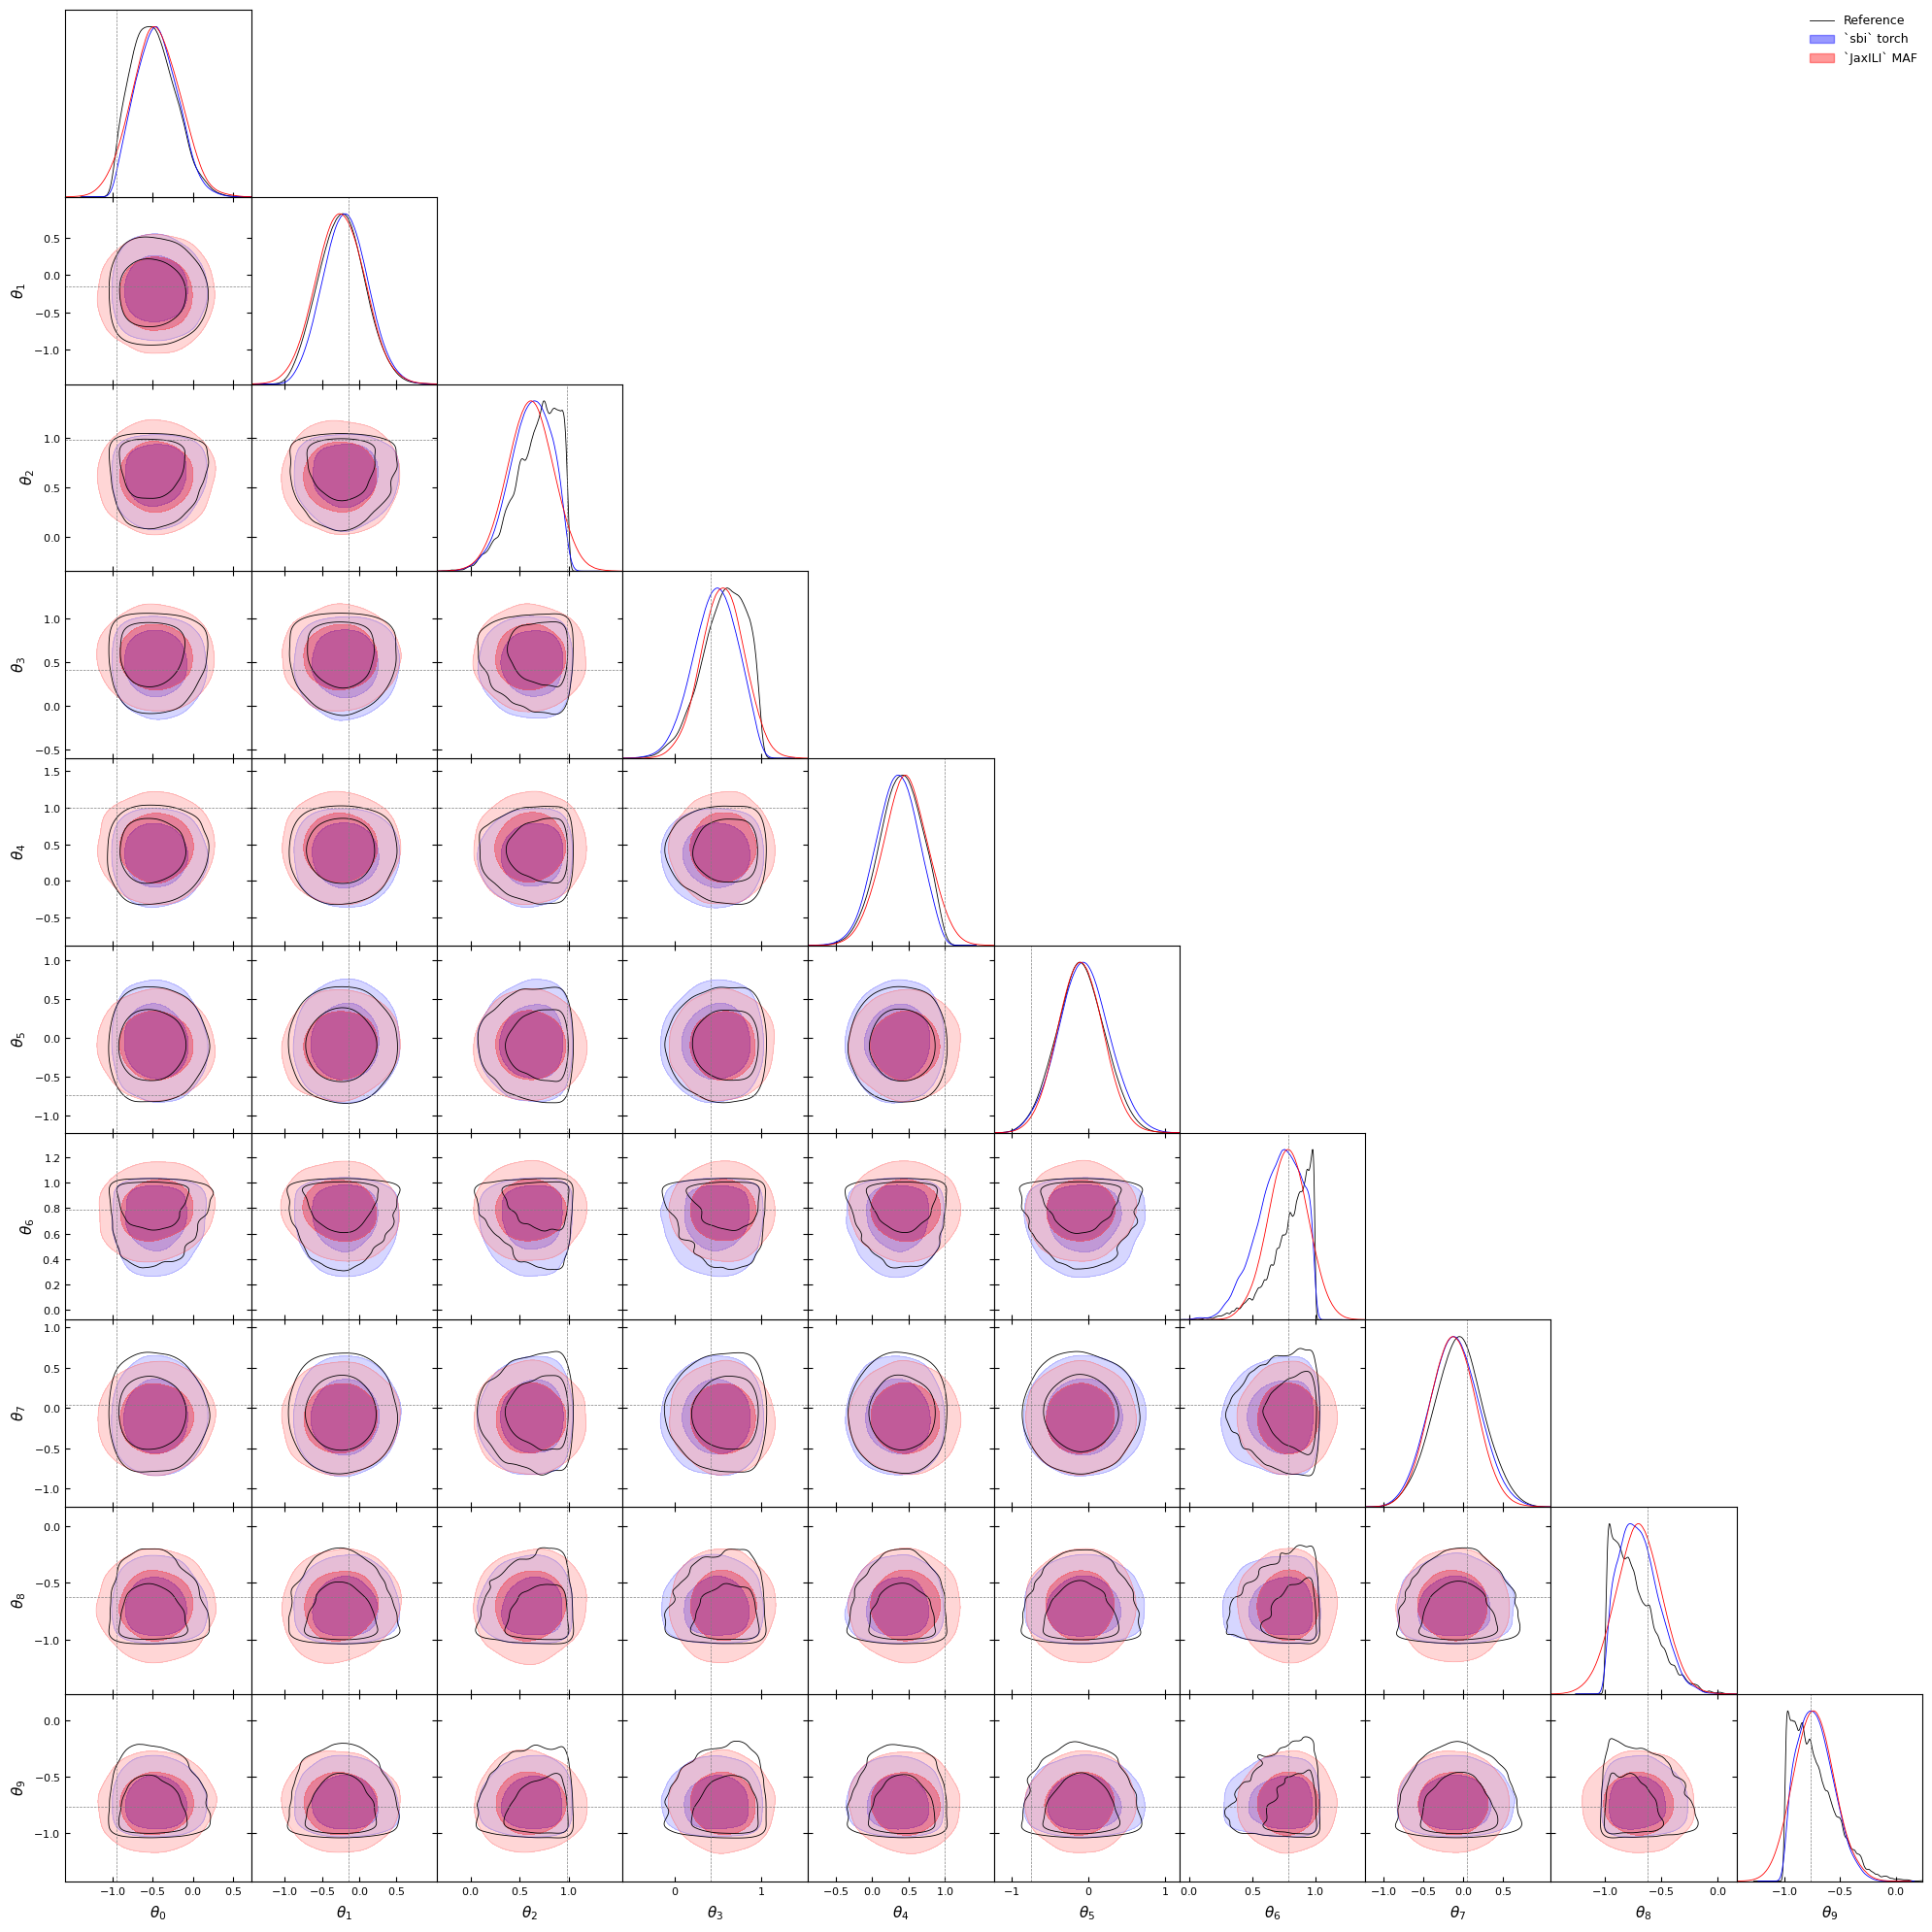

In [21]:
labels = [rf'\theta_{i}' for i in range(10)]

reference_samples_gd = MCSamples(samples=reference_samples, names=labels,
                                 labels=labels)

sbi_samples_gd = MCSamples(samples=sbi_samples.to('cpu').detach().numpy(), names=labels, labels=labels)
jaxili_samples_gd = MCSamples(samples=samples_maf_npe, names=labels, labels=labels)

g = plots.get_subplot_plotter()

g.settings.figure_legend_frame = False
g.settings.alpha_filled_add = 0.4

g.triangle_plot([reference_samples_gd, sbi_samples_gd, jaxili_samples_gd],
                filled=[False, True],
                legend_labels=["Reference", "`sbi` torch", "`JaxILI` MAF"],
                legend_loc="upper right",
                line_args=[
                    {'color': 'black'},
                    {'color': 'blue'},
                    {'color': 'red'}
                ],
                contour_colors=['black', 'blue', 'red'],
                markers={
                    label: val for label, val in zip(labels, truth) 
                }
               )

plt.show()

## 2. Two Moons

- Prior: $\mathcal{U}(-1, 1)$
- Simulator: $x|\theta \sim \left[\begin{array}{c} r\cos(\alpha)+0.25 \\ r\sin(\alpha)\end{array}\right]+\left[ \begin{array}{c} -|\theta_1+\theta_2|/\sqrt{2}\\ (-\theta_1+\theta_2)/\sqrt{2} \end{array}\right]$ where $\alpha \sim \mathcal{U}(-\pi/2, \pi/2)$ and $r \sim \mathcal{N}(0.1, 0.01^2)$
- $\theta \in \mathbb{R}^2$, $x\in \mathbb{R}^2$

In [22]:
#Let's fetch the task from sbibm
task = sbibm.get_task('two_moons')
prior = task.get_prior()  #Returns an object that allows to sample from the prior
simulator = task.get_simulator()  #Returns the simulator function
reference_samples = jnp.array(task.get_reference_posterior_samples(num_observation=1))  #Returns the reference samples
observation = jnp.array(task.get_observation(num_observation=1)) #Returns the observation
truth = jnp.array(task.get_true_parameters(num_observation=1).flatten()) #Returns the true parameters

dim_theta = truth.shape[0]
dim_obs = observation.shape[1]

print(f"Dimension of theta: {dim_theta}")
print(f"Dimension of observation: {dim_obs}")
print(f"True parameters: {truth}")

Dimension of theta: 2
Dimension of observation: 2
True parameters: [-0.8176656 -0.5756806]


In [23]:
train_set = SimulationDataset(simulator, prior, 20000)
val_set = SimulationDataset(simulator, prior, 5000)
test_set = SimulationDataset(simulator, prior, 5000)

train_loader, val_loader, test_loader = create_data_loader(
    train_set, val_set, test_set,
    train=[True, False, False],
    batch_size = 128
)

train_set_jax = jdl.ArrayDataset(train_set.theta, train_set.x)
val_set_jax = jdl.ArrayDataset(val_set.theta, val_set.x)
test_set_jax = jdl.ArrayDataset(test_set.theta, test_set.x)

train_loader_jax = jdl.DataLoader(train_set_jax, backend='jax', batch_size=128, shuffle=True, drop_last=True)
val_loader_jax = jdl.DataLoader(val_set_jax, backend='jax', batch_size=128, shuffle=False, drop_last=False)
test_loader_jax = jdl.DataLoader(test_set_jax, backend='jax', batch_size=128, shuffle=False, drop_last=False)

### Let's first use Neural Posterior Estimation

### Using `sbi` library

In [24]:
prior_inf = BoxUniform(low = -torch.ones(2), high=torch.ones(2), device=device)

In [25]:
#Create the inference object
inference = NPE(prior=prior_inf, device=device)
theta, sim = train_set[:]
theta, sim = torch.tensor(theta, dtype=torch.float32).to(device), torch.tensor(sim, dtype=torch.float32).to(device)

In [26]:
#Train !!!
inference = inference.append_simulations(theta, sim)
density_estimator = inference.train()

 Neural network successfully converged after 217 epochs.

In [27]:
posterior = inference.build_posterior()
print(posterior)

Posterior p(θ|x) of type DirectPosterior. It samples the posterior network and rejects samples that
            lie outside of the prior bounds.


In [28]:
x_obs = torch.from_numpy(np.array(observation)).to(device)

In [29]:
sbi_samples = posterior.sample((10_000,), x=x_obs)

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in
Removed no burn in


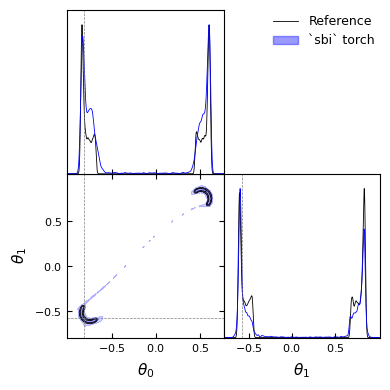

In [30]:
labels = [rf'\theta_{i}' for i in range(2)]

reference_samples_gd = MCSamples(samples=reference_samples, names=labels,
                                 labels=labels)

sbi_samples_gd = MCSamples(samples=sbi_samples.to('cpu').detach().numpy(), names=labels, labels=labels)

g = plots.get_subplot_plotter()

g.settings.figure_legend_frame = False
g.settings.alpha_filled_add = 0.4

g.triangle_plot([reference_samples_gd, sbi_samples_gd],
                filled=[False, True],
                legend_labels=["Reference", "`sbi` torch"],
                legend_loc="upper right",
                line_args=[
                    {'color': 'black'},
                    {'color': 'blue'}
                ],
                contour_colors=['black', 'blue'],
                markers={
                    label: val for label, val in zip(labels, truth) 
                }
               )

plt.show()

## Using `JaxILI`

In [31]:
learning_rate = 5e-4
batch_size = 128
checkpoint_path = "./checkpoints_GL_tm/"
checkpoint_path = os.path.abspath(checkpoint_path)

inference = NPE_JAX()

inference.set_dataset(train_set, type="train")
inference.set_dataset(val_set, type="val")
inference.set_dataset(test_set, type="test")

inference._dim_params = dim_theta
inference._dim_cond = dim_obs
inference._num_sims = len(train_set) + len(val_set) + len(test_set)

_, density_estimator = inference.train(
    training_batch_size=batch_size,
    learning_rate=learning_rate,
    checkpoint_path=checkpoint_path
)

posterior = inference.build_posterior()

[!] Creating DataLoaders with batch_size 128.
[!] Building the neural network.


Missing logger folder: /home/sacha/Documents/jaxili/notebooks/checkpoints_GL_tm/NDE_w_Standardization/


[!] Creating the Trainer module.
Could not tabulate model: 


[!] Training the density estimator.


Epochs: Val loss -3.370/ Best val loss -3.386:   0%|          | 175/2147483647 [02:45<562518:32:19,  1.06it/s]

Neural network training stopped after 176 epochs.
Early stopping with best validation metric: -3.38566255569458
Best model saved at epoch 155
Early stopping parameters: min_delta=0.001, patience=20


[!] Training loss: -3.3110105991363525
[!] Validation loss: -3.38566255569458
[!] Test loss: -3.3361918926239014
[!] Posterior $p(\theta| x)$ built. The class DirectPosterior is used to sample and evaluate the log probability.


In [34]:
key, master_key = jax.random.split(master_key)
samples_maf_npe = posterior.sample(
    x=observation, num_samples=10000, key=key
)

Removed no burn in
Removed no burn in
Removed no burn in


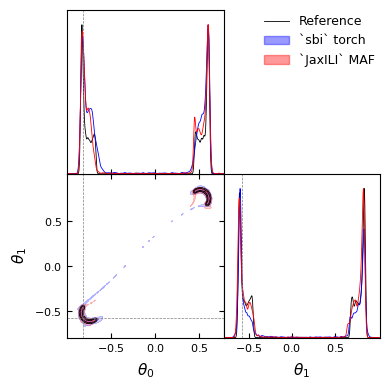

In [35]:
labels = [rf'\theta_{i}' for i in range(2)]

reference_samples_gd = MCSamples(samples=reference_samples, names=labels,
                                 labels=labels)

sbi_samples_gd = MCSamples(samples=sbi_samples.to('cpu').detach().numpy(), names=labels, labels=labels)
jaxili_samples_gd = MCSamples(samples=samples_maf_npe, names=labels, labels=labels)

g = plots.get_subplot_plotter()

g.settings.figure_legend_frame = False
g.settings.alpha_filled_add = 0.4

g.triangle_plot([reference_samples_gd, sbi_samples_gd, jaxili_samples_gd],
                filled=[False, True],
                legend_labels=["Reference", "`sbi` torch", "`JaxILI` MAF"],
                legend_loc="upper right",
                line_args=[
                    {'color': 'black'},
                    {'color': 'blue'},
                    {'color': 'red'}
                ],
                contour_colors=['black', 'blue', 'red'],
                markers={
                    label: val for label, val in zip(labels, truth) 
                }
               )

plt.show()

## 3. SLCP

- Prior: $\mathcal{U}(-3, 3)$
- Simulator: $x|\theta=(x_1, x_2, x_3, x_4), x_i \sim \mathcal{N}(m_{\theta}, S_{\theta})$
where $m_{\theta} = \left[\begin{array}{c}\theta_1 \\ \theta_2 \end{array}\right]$ and $S_{\theta} = \left[ \begin{array}{cc} s_1^2 & \rho s_1 s_2 \\ \rho s_1 s_2 & s_2^2 \end{array}\right]$, $s_1=\theta_3^2$, $s_2=\theta_4^2$, $\rho=\tanh{\theta_5}$
- $\theta \in \mathbb{R}^5$, $x\in \mathbb{R}^8$

In [36]:
#Let's fetch the task from sbibm
task = sbibm.get_task('slcp')
prior = task.get_prior()  #Returns an object that allows to sample from the prior
simulator = task.get_simulator()  #Returns the simulator function
reference_samples = jnp.array(task.get_reference_posterior_samples(num_observation=1))  #Returns the reference samples
observation = jnp.array(task.get_observation(num_observation=1)) #Returns the observation
truth = jnp.array(task.get_true_parameters(num_observation=1).flatten()) #Returns the true parameters

dim_theta = truth.shape[0]
dim_obs = observation.shape[1]

print(f"Dimension of theta: {dim_theta}")
print(f"Dimension of observation: {dim_obs}")
print(f"True parameters: {truth}")

Dimension of theta: 5
Dimension of observation: 8
True parameters: [-2.8581212  -0.44451332  2.9473476   1.2396116   2.9712725 ]


In [38]:
train_set = SimulationDataset(simulator, prior, 20000)
val_set = SimulationDataset(simulator, prior, 5000)
test_set = SimulationDataset(simulator, prior, 5000)

train_loader, val_loader, test_loader = create_data_loader(
    train_set, val_set, test_set,
    train=[True, False, False],
    batch_size = 128
)

train_set_jax = jdl.ArrayDataset(train_set.theta, train_set.x)
val_set_jax = jdl.ArrayDataset(val_set.theta, val_set.x)
test_set_jax = jdl.ArrayDataset(test_set.theta, test_set.x)

train_loader_jax = jdl.DataLoader(train_set_jax, backend='jax', batch_size=128, shuffle=True, drop_last=True)
val_loader_jax = jdl.DataLoader(val_set_jax, backend='jax', batch_size=128, shuffle=False, drop_last=False)
test_loader_jax = jdl.DataLoader(test_set_jax, backend='jax', batch_size=128, shuffle=False, drop_last=False)

### Let's first use Neural Posterior Estimation

### Using `sbi` library

In [39]:
prior_inf = BoxUniform(low = -3*torch.ones(5), high=3*torch.ones(5), device=device)

In [40]:
#Create the inference object
inference = NPE(prior=prior_inf, device=device)
theta, sim = train_set[:]
theta, sim = torch.tensor(theta, dtype=torch.float32).to(device), torch.tensor(sim, dtype=torch.float32).to(device)

In [41]:
#Train !!!
inference = inference.append_simulations(theta, sim)
density_estimator = inference.train()

 Neural network successfully converged after 242 epochs.

In [42]:
posterior = inference.build_posterior()
print(posterior)

Posterior p(θ|x) of type DirectPosterior. It samples the posterior network and rejects samples that
            lie outside of the prior bounds.


In [43]:
x_obs = torch.from_numpy(np.array(observation)).to(device)

In [44]:
sbi_samples = posterior.sample((10_000,), x=x_obs)

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in
Removed no burn in


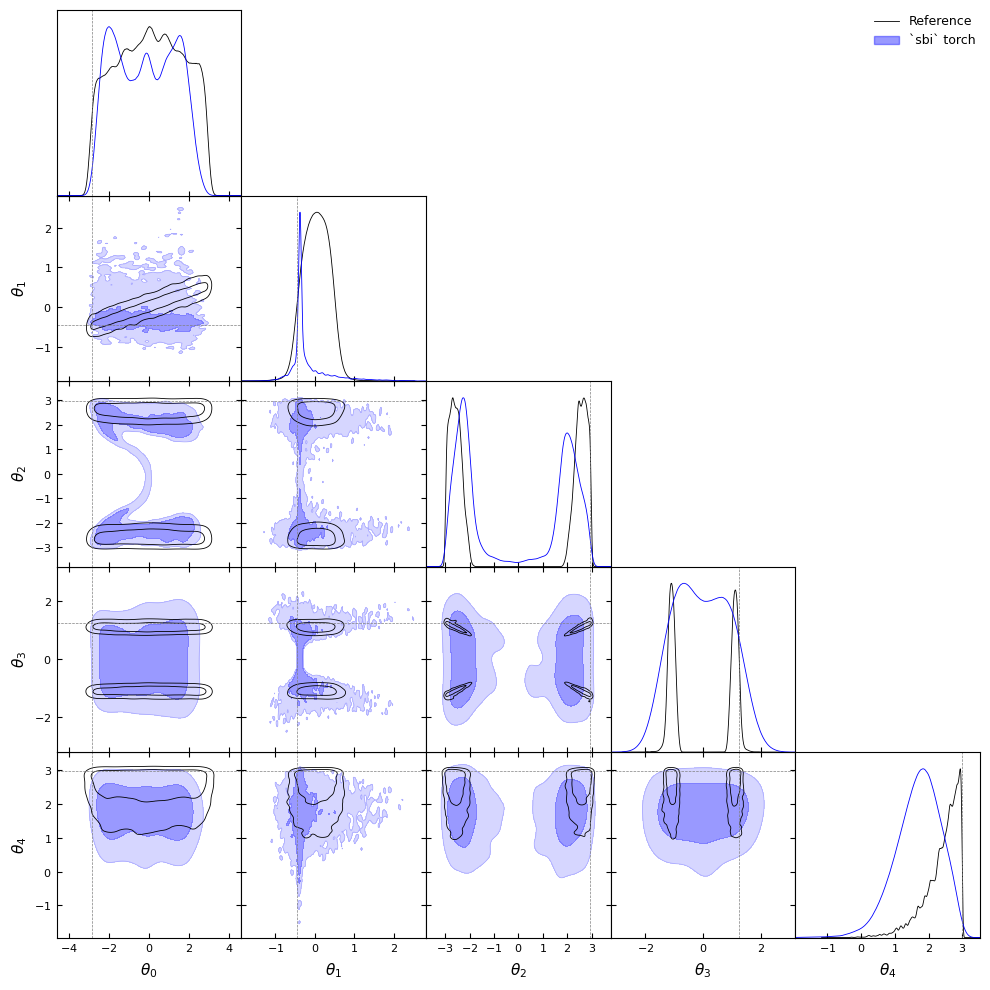

In [45]:
labels = [rf'\theta_{i}' for i in range(5)]

reference_samples_gd = MCSamples(samples=reference_samples, names=labels,
                                 labels=labels)

sbi_samples_gd = MCSamples(samples=sbi_samples.to('cpu').detach().numpy(), names=labels, labels=labels)

g = plots.get_subplot_plotter()

g.settings.figure_legend_frame = False
g.settings.alpha_filled_add = 0.4

g.triangle_plot([reference_samples_gd, sbi_samples_gd],
                filled=[False, True],
                legend_labels=["Reference", "`sbi` torch"],
                legend_loc="upper right",
                line_args=[
                    {'color': 'black'},
                    {'color': 'blue'}
                ],
                contour_colors=['black', 'blue'],
                markers={
                    label: val for label, val in zip(labels, truth) 
                }
               )

plt.show()

## Using `JaxILI`

In [46]:
learning_rate = 5e-4
batch_size = 128
checkpoint_path = "./checkpoints_GL_slcp/"
checkpoint_path = os.path.abspath(checkpoint_path)

inference = NPE_JAX()

inference.set_dataset(train_set, type="train")
inference.set_dataset(val_set, type="val")
inference.set_dataset(test_set, type="test")

inference._dim_params = dim_theta
inference._dim_cond = dim_obs
inference._num_sims = len(train_set) + len(val_set) + len(test_set)

_, density_estimator = inference.train(
    training_batch_size=batch_size,
    learning_rate=learning_rate,
    checkpoint_path=checkpoint_path
)

posterior = inference.build_posterior()

[!] Creating DataLoaders with batch_size 128.
[!] Building the neural network.


Missing logger folder: /home/sacha/Documents/jaxili/notebooks/checkpoints_GL_slcp/NDE_w_Standardization/


[!] Creating the Trainer module.
Could not tabulate model: 


[!] Training the density estimator.


Epochs: Val loss 4.571/ Best val loss 4.566:   0%|          | 220/2147483647 [09:21<1523013:49:23,  2.55s/it]

Neural network training stopped after 221 epochs.
Early stopping with best validation metric: 4.5659966468811035
Best model saved at epoch 200
Early stopping parameters: min_delta=0.001, patience=20


[!] Training loss: 4.307651996612549
[!] Validation loss: 4.5659966468811035
[!] Test loss: 4.6373610496521
[!] Posterior $p(\theta| x)$ built. The class DirectPosterior is used to sample and evaluate the log probability.


In [47]:
key, master_key = jax.random.split(master_key)
samples_maf_npe = posterior.sample(
    x=observation, num_samples=10000, key=key
)

Removed no burn in
Removed no burn in
Removed no burn in


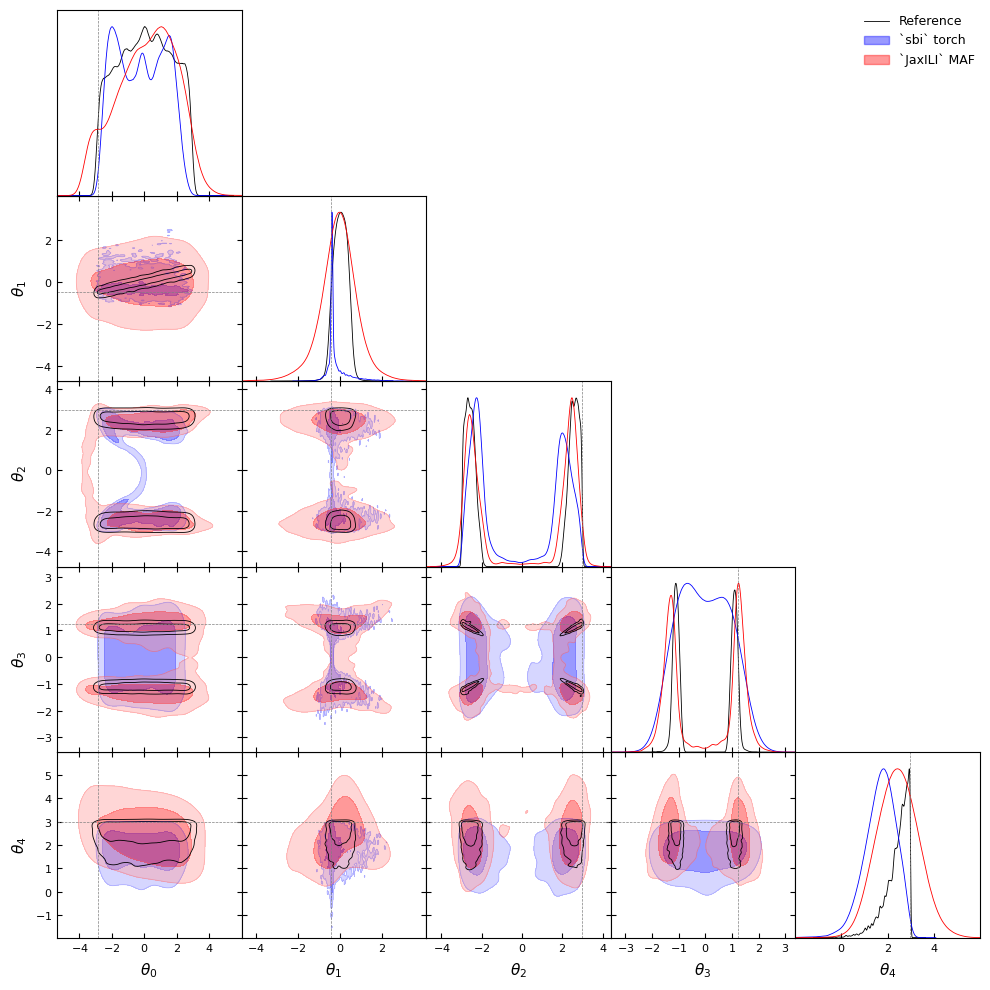

In [48]:
labels = [rf'\theta_{i}' for i in range(5)]

reference_samples_gd = MCSamples(samples=reference_samples, names=labels,
                                 labels=labels)

sbi_samples_gd = MCSamples(samples=sbi_samples.to('cpu').detach().numpy(), names=labels, labels=labels)
jaxili_samples_gd = MCSamples(samples=samples_maf_npe, names=labels, labels=labels)

g = plots.get_subplot_plotter()

g.settings.figure_legend_frame = False
g.settings.alpha_filled_add = 0.4

g.triangle_plot([reference_samples_gd, sbi_samples_gd, jaxili_samples_gd],
                filled=[False, True],
                legend_labels=["Reference", "`sbi` torch", "`JaxILI` MAF"],
                legend_loc="upper right",
                line_args=[
                    {'color': 'black'},
                    {'color': 'blue'},
                    {'color': 'red'}
                ],
                contour_colors=['black', 'blue', 'red'],
                markers={
                    label: val for label, val in zip(labels, truth) 
                }
               )

plt.show()

## 4. An example in cosmology

In [49]:
try:
    import jax_cosmo as jc
except:
    %pip install jax-cosmo -q
    import jax_cosmo as jc

try:
    import haiku as hk
except:
    %pip install dm-haiku -q
    import haiku as hk

In cosmology, we study the expansion history and the matter content of the Universe by computing correlations between different observables (e.g. galaxy positions, galaxy shapes, CMB polarization,...). The correlation can be computed in real space in which case we refer to the 2-point correlation function (2PCF) $\xi(\theta)$ where $\theta$ is the angular distance between two galaxies. The analysis can also be done in Fourier space in which we measure the power spectrum (i.e. the Fourier transform of the 2PCF).

![Weak lensing](https://www.cosmostat.org/wp-content/uploads/2017/06/draufsicht_corr-1.png)

In what follows, we use the package `jax_cosmo` to simulate weak lensing angular power spectra at various cosmology. It will play the role of our dataset to run Implicit Likelihood Inference. The goal is to infer the cosmological parameters that describe the expansion history and matter content of the Universe (go [here](https://en.wikipedia.org/wiki/Lambda-CDM_model) for more details)

In [50]:
#Let's create a cosmology with fiducial parameters
cosmo = jc.Planck15()

fiducial_params = jnp.array([cosmo.Omega_c, cosmo.sigma8]) #These cosmological parameters will be the fiducial parameters
cosmo

Cosmological parameters: 
    h:        0.6774 
    Omega_b:  0.0486 
    Omega_c:  0.2589 
    Omega_k:  0.0 
    w0:       -1.0 
    wa:       0.0 
    n:        0.9667 
    sigma8:   0.8159

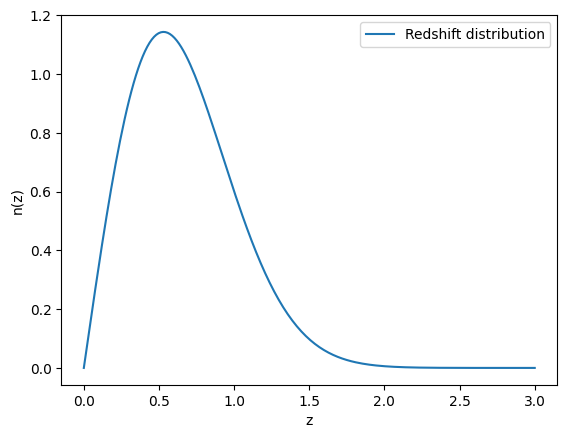

In [51]:
#The power spectrum depends on the cosmology but also on the redshift distribution of galaxies.*
#Let's create a simple redshift distribution
nz = jc.redshift.smail_nz(1., 2., 0.75, gals_per_arcmin2=30)

#and let's have a look at the redshift distribution
z = np.linspace(0, 3, 200)
plt.figure()

plt.plot(z, nz(z), label='Redshift distribution')
plt.xlabel('z')
plt.ylabel('n(z)')
plt.legend()
plt.show()

In [52]:
#We can then use this redshift distribution to predict the power spectrum of cosmic shear/weak lensing
tracer = jc.probes.WeakLensing([nz])

ell = jnp.logspace(1, np.log10(2000), 20) #We will use 20 bins in ell

#Compute the mean and covariance matrix for this cosmology and this tracer
mu, cov = jc.angular_cl.gaussian_cl_covariance_and_mean(cosmo, ell, [tracer], f_sky=0.125)

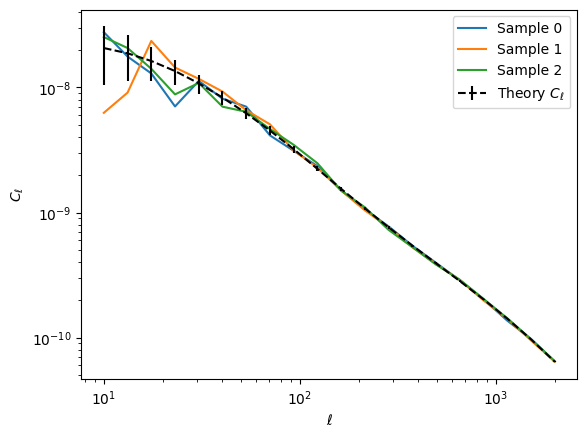

In [53]:
#Let's sample a few Cl's from this distribution
key = jax.random.PRNGKey(42)

plt.figure()

for i in range(3):
    key, _ = jax.random.split(key)
    Cl = jax.random.multivariate_normal(key, mu, cov)
    plt.plot(ell, Cl, label=f'Sample {i}')

plt.errorbar(ell, mu, yerr=jnp.sqrt(jnp.diag(cov)), label=r'Theory $C_{\ell}$', color='k', linestyle='--')

plt.xlabel(r'$\ell$')
plt.ylabel(r'$C_{\ell}$')

plt.legend()

plt.xscale('log')
plt.yscale('log')

plt.show()

As `jax_cosmo` provides the mean and the covariance of the $C_{\ell}$'s, we can create a simulator that returns a power spectrum sampled from the mean and covariance returned by `jax_cosmo`. In this notebook, we will only focus on the parameters $\Omega_c$, the dark matter content of the Universe, and $\sigma_8$, which quantifies the "clumpiness" of the Universe.

In [54]:
#Let's define the simulator
@jax.jit #This is a jax decorator that makes the function faster
def simulator(params, key): #with jax a key must be given to be able to generate random numbers
    cosmo = jc.Planck15(Omega_c=params[0], sigma8=params[1])
    mu, cov = jc.angular_cl.gaussian_cl_covariance_and_mean(cosmo, ell, [tracer], f_sky=0.125)
    Cl = jax.random.multivariate_normal(key, mu, cov)
    return Cl

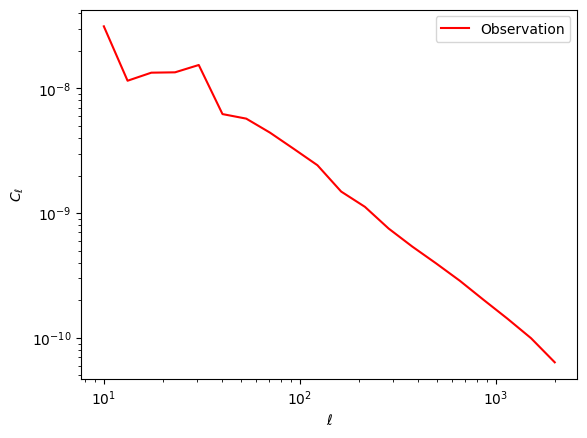

In [55]:
#Let's fetch an observation from the simulator
key = jax.random.PRNGKey(0)
observation = simulator(fiducial_params, key)

plt.figure()

plt.plot(ell, observation, label='Observation', color='red')

plt.xlabel(r'$\ell$')
plt.ylabel(r'$C_{\ell}$')

plt.legend()

plt.xscale('log')
plt.yscale('log')

plt.show()


In [56]:
import scipy.stats as stats
#Let's generate the training set. We first need to collect cosmological parameters sampled from the prior.
#We will use a uniform prior on Omega_c and sigma8
dim_theta = 2
dim_obs = 20

num_train = 50_000

thetas_train = stats.qmc.LatinHypercube(d=2).random(num_train) #We use LatinHypercube to optimally sample the parameter space
thetas_train = stats.qmc.scale(thetas_train, np.array([0.0, 0.0]), np.array([1.0, 1.5]))

x_train = []
master_key = jax.random.PRNGKey(42)
for th in tqdm(thetas_train):
    key, master_key = jax.random.split(key)
    x_train.append(simulator(th, key))
x_train = jnp.array(x_train)

100%|██████████| 50000/50000 [12:35<00:00, 66.17it/s]


In [57]:
#We are going to use the `sbi` library that uses torch so we have to convert the data to torch
theta_train_torch = torch.tensor(np.array(thetas_train), dtype=torch.float32)
x_train_torch = torch.tensor(np.array(x_train), dtype=torch.float32)

In [58]:
theta_train_torch = theta_train_torch.to(device)
x_train_torch = x_train_torch.to(device)

### Using `sbi`

In [59]:
prior_sbi = BoxUniform(low=torch.tensor([0.0, 0.0]), high=torch.tensor([1.0, 1.5]), device=device)

In [60]:
#Let's start with NPE
inference_npe = NPE(prior=prior_sbi, device=device)
inference_npe = inference_npe.append_simulations(theta=theta_train_torch, x=x_train_torch)
density_estimator_npe = inference_npe.train()

 Neural network successfully converged after 130 epochs.

In [61]:
posterior_npe = inference_npe.build_posterior()
print(posterior_npe)

Posterior p(θ|x) of type DirectPosterior. It samples the posterior network and rejects samples that
            lie outside of the prior bounds.


In [62]:
observation_torch = torch.tensor(np.array(observation), dtype=torch.float32)

npe_samples = posterior_npe.sample((10_000,), x=observation_torch.to(device))

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

In [63]:
npe_samples = npe_samples.cpu().numpy() #Let's send it back to the CPU

Removed no burn in


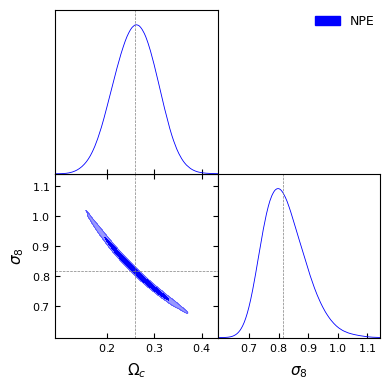

In [64]:
#And have a look at the posterior
labels = [r'\Omega_c', r'\sigma_8']

npe_samples_gd = MCSamples(samples=npe_samples, names=labels,
                                 labels=labels)

g = plots.get_subplot_plotter()

g.settings.figure_legend_frame = False
g.settings.alpha_filled_add = 0.4

g.triangle_plot([npe_samples_gd],
                filled=[True],
                legend_labels=["NPE"],
                line_args=[
                    {'color': 'blue'},
                ],
                contour_colors=['blue'],
                markers={
                    label: val for label, val in zip(labels, fiducial_params)
                }
               )

plt.show()


We can see that $\Omega_c$ and $\sigma_8$ are degenerate. In cosmology, we usually look at the value of $S_8=\sigma_8 \sqrt{\Omega_m/0.3}$.

In [65]:
get_S_8 = lambda Omega_c, sigma8: sigma8 * ((Omega_c+cosmo.Omega_b) / 0.3)**0.5
get_Omega_m = lambda Omega_c: Omega_c + cosmo.Omega_b

fiducial_params = jnp.array([cosmo.Omega_c, cosmo.sigma8, get_S_8(cosmo.Omega_c, cosmo.sigma8), get_Omega_m(cosmo.Omega_c)]) #Add S8 and Omega_m to the fiducial

In [66]:
npe_S_8 = get_S_8(npe_samples[:, 0], npe_samples[:, 1])
npe_Omega_m = get_Omega_m(npe_samples[:, 0])
npe_samples_S8 = np.column_stack((npe_samples, npe_S_8, npe_Omega_m))

Removed no burn in


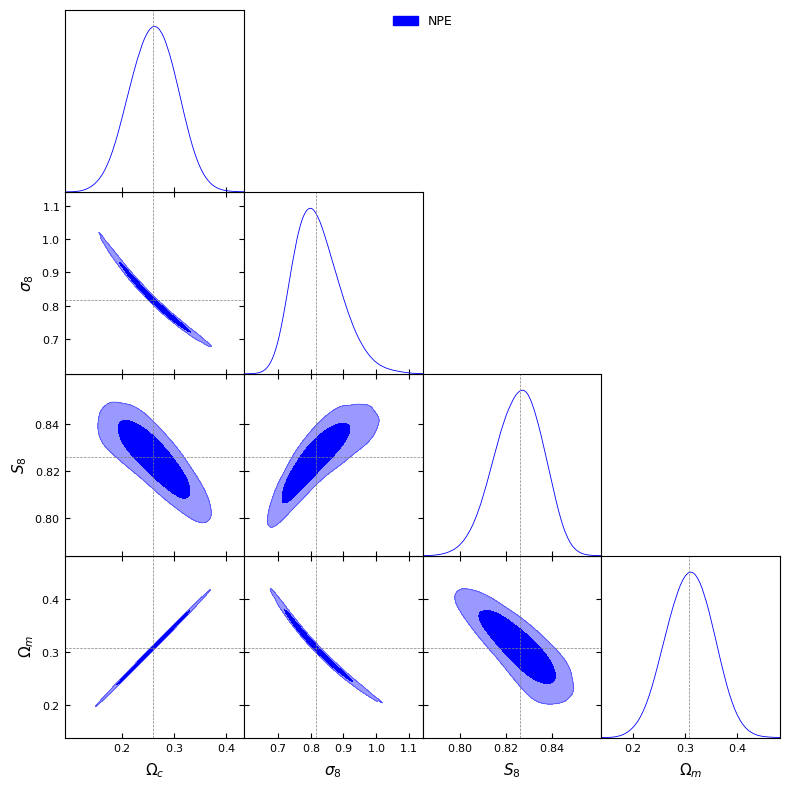

In [67]:
#And have a look at the posterior
labels = [r'\Omega_c', r'\sigma_8', r'S_8', r'\Omega_m']

npe_samples_gd = MCSamples(samples=npe_samples_S8, names=labels,
                                 labels=labels)

g = plots.get_subplot_plotter()

g.settings.figure_legend_frame = False
g.settings.alpha_filled_add = 0.4

g.triangle_plot([npe_samples_gd],
                filled=[True],
                legend_labels=["NPE"],
                line_args=[
                    {'color': 'blue'},
                ],
                contour_colors=['blue'],
                markers={
                    label: val for label, val in zip(labels, fiducial_params)
                }
               )

plt.show()

### Using `JaxILI`

In [68]:
thetas_train, x_train = np.array(thetas_train, dtype=np.float32), np.array(x_train, dtype=np.float32)

In [69]:
learning_rate = 5e-4
batch_size = 128
checkpoint_path = "./checkpoints_PS_jaxcosmo/"
checkpoint_path = os.path.abspath(checkpoint_path)

inference = NPE_JAX()

mask = (jnp.isnan(x_train).sum(axis=-1) == 0)
inference.append_simulations(thetas_train[mask], x_train[mask])

_, density_estimator = inference.train(
    training_batch_size=batch_size,
    learning_rate=learning_rate,
    checkpoint_path=checkpoint_path
)

posterior = inference.build_posterior()

[!] Inputs are valid.
[!] Appending 49999 simulations to the dataset.
[!] Dataset split into training, validation and test sets.
[!] Training set: 34999 simulations.
[!] Validation set: 10000 simulations.
[!] Test set: 5000 simulations.
[!] Creating DataLoaders with batch_size 128.
[!] Building the neural network.


Missing logger folder: /home/sacha/Documents/jaxili/notebooks/checkpoints_PS_jaxcosmo/NDE_w_Standardization/


[!] Creating the Trainer module.
Could not tabulate model: 


[!] Training the density estimator.


Epochs: Val loss -5.451/ Best val loss -5.680:   0%|          | 108/2147483647 [00:45<253007:54:57,  2.36it/s]

Neural network training stopped after 109 epochs.
Early stopping with best validation metric: -5.6804118156433105
Best model saved at epoch 88
Early stopping parameters: min_delta=0.001, patience=20


[!] Training loss: -5.4330878257751465
[!] Validation loss: -5.6804118156433105
[!] Test loss: -5.368732452392578
[!] Posterior $p(\theta| x)$ built. The class DirectPosterior is used to sample and evaluate the log probability.


In [70]:
key, master_key = jax.random.split(master_key)
samples_maf_npe = posterior.sample(
    x=observation, num_samples=10000, key=key
)

Removed no burn in
Removed no burn in


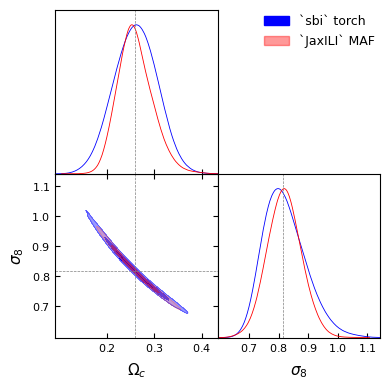

In [71]:
#And have a look at the posterior
labels = [r'\Omega_c', r'\sigma_8']

npe_samples_gd = MCSamples(samples=npe_samples, names=labels,
                                 labels=labels)

jaxili_samples_gd = MCSamples(samples=samples_maf_npe, names=labels, labels=labels)

g = plots.get_subplot_plotter()

g.settings.figure_legend_frame = False
g.settings.alpha_filled_add = 0.4

g.triangle_plot([npe_samples_gd, jaxili_samples_gd],
                filled=[True],
                legend_labels=["`sbi` torch", "`JaxILI` MAF"],
                line_args=[
                    {'color': 'blue'},
                    {'color': 'red'},
                ],
                contour_colors=['blue', 'red'],
                markers={
                    label: val for label, val in zip(labels, fiducial_params)
                }
               )

plt.show()

In [72]:
npe_S_8 = get_S_8(samples_maf_npe[:, 0], samples_maf_npe[:, 1])
npe_Omega_m = get_Omega_m(samples_maf_npe[:, 0])
samples_maf_npe_S8 = np.column_stack((samples_maf_npe, npe_S_8, npe_Omega_m))

Removed no burn in
Removed no burn in


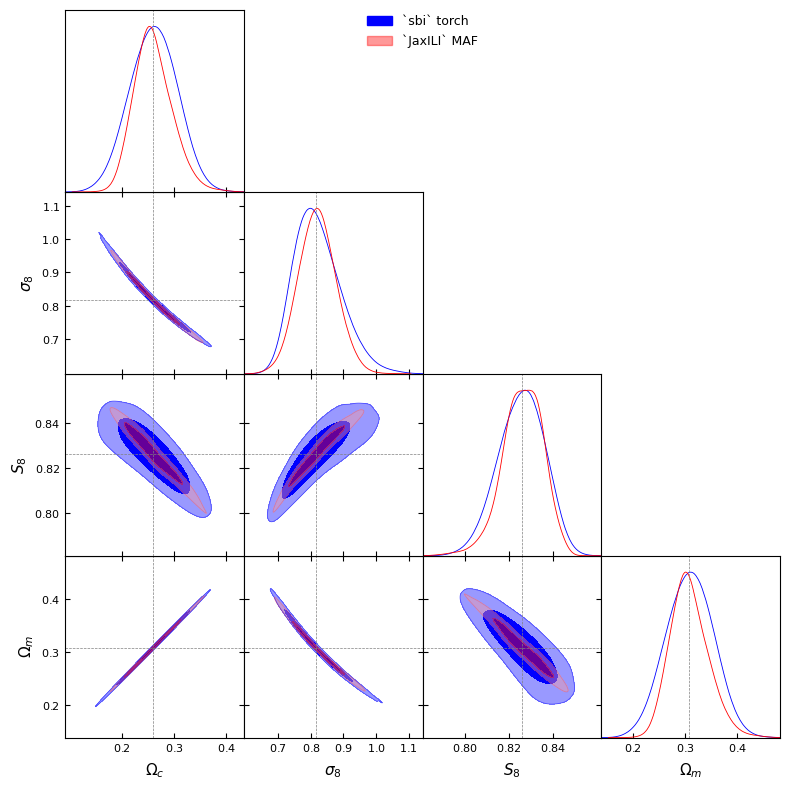

In [73]:
#And have a look at the posterior
labels = [r'\Omega_c', r'\sigma_8', r'S_8', r'\Omega_m']

npe_samples_gd = MCSamples(samples=npe_samples_S8, names=labels,
                                 labels=labels)
jaxili_samples_gd = MCSamples(samples=samples_maf_npe_S8, names=labels, labels=labels)

g = plots.get_subplot_plotter()

g.settings.figure_legend_frame = False
g.settings.alpha_filled_add = 0.4

g.triangle_plot([npe_samples_gd, jaxili_samples_gd],
                filled=[True],
                legend_labels=["`sbi` torch", "`JaxILI` MAF"],
                line_args=[
                    {'color': 'blue'},
                    {'color': 'red'},
                ],
                contour_colors=['blue', 'red'],
                markers={
                    label: val for label, val in zip(labels, fiducial_params)
                }
               )

plt.show()

### Drawing reference samples

We can use HMC to draw from the true likelihood.

In [77]:
import blackjax

_, cov_fid = jc.angular_cl.gaussian_cl_covariance_and_mean(cosmo, ell, [tracer], f_sky=0.125)
inv_cov_fid = jnp.linalg.inv(cov_fid)

def log_prior(theta):
    Omega_c, sigma8 = theta
    log_prior = jnp.where(Omega_c<1.0, 0., -jnp.inf)
    log_prior =  jnp.where(Omega_c>0.0, log_prior, -jnp.inf)
    log_prior = jnp.where(sigma8<1.5, log_prior, -jnp.inf)
    log_prior = jnp.where(sigma8>0.0, log_prior, -jnp.inf)
    return log_prior

def log_likelihood(theta):
    cosmo = jc.Planck15(Omega_c=theta[0], sigma8=theta[1])
    mu, cov = jc.angular_cl.gaussian_cl_covariance_and_mean(cosmo, ell, [tracer], f_sky=0.125)
    inv_cov = jnp.linalg.inv(cov)
    mu = mu.squeeze()
    return -0.5*(mu - observation).T @ inv_cov @ (mu - observation)

@jax.jit
def log_prob(theta):
    return log_prior(theta) + log_likelihood(theta)

In [78]:
%timeit log_prob(jnp.array([0.3, 0.8]))

11.2 ms ± 1.38 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [79]:
import emcee

n_dim = 2
n_walkers = 32
n_steps = 5000

initial = jnp.array([0.3, 0.8])
initial = jnp.repeat(initial[None, :], n_walkers, axis=0)
initial = initial + 1e-3*jax.random.normal(jax.random.PRNGKey(42), shape=(n_walkers, n_dim))

sampler = emcee.EnsembleSampler(n_walkers, n_dim, log_prob)

sampler.run_mcmc(initial, n_steps, progress=True)

100%|██████████| 5000/5000 [22:47<00:00,  3.66it/s]


State([[0.27706507 0.7915018 ]
 [0.26013994 0.8156285 ]
 [0.28856626 0.7752856 ]
 [0.26887017 0.80291283]
 [0.24112403 0.84594   ]
 [0.23405784 0.8570658 ]
 [0.27152678 0.7970292 ]
 [0.26959306 0.79919744]
 [0.27147964 0.8006385 ]
 [0.252739   0.8288046 ]
 [0.22125119 0.8814185 ]
 [0.24981064 0.8302143 ]
 [0.24443446 0.8411343 ]
 [0.2320388  0.8622185 ]
 [0.2526552  0.8297504 ]
 [0.24549839 0.84041363]
 [0.22446668 0.87633616]
 [0.23103018 0.86252236]
 [0.2549397  0.8267435 ]
 [0.2560414  0.82288635]
 [0.24982545 0.8340093 ]
 [0.23701233 0.85446835]
 [0.24939814 0.83139086]
 [0.25298548 0.8277235 ]
 [0.24493021 0.8397297 ]
 [0.26446426 0.8068138 ]
 [0.24923748 0.8329608 ]
 [0.23944262 0.8498102 ]
 [0.22917123 0.86530083]
 [0.234641   0.85820335]
 [0.25359505 0.8269884 ]
 [0.2502084  0.832524  ]], log_prob=[-13.42176151 -12.91645718 -14.23159122 -13.03645802 -13.1748333
 -14.07149506 -14.6802969  -15.62067413 -13.55994034 -12.95227242
 -14.87764263 -14.23158264 -12.89139843 -13.63981724

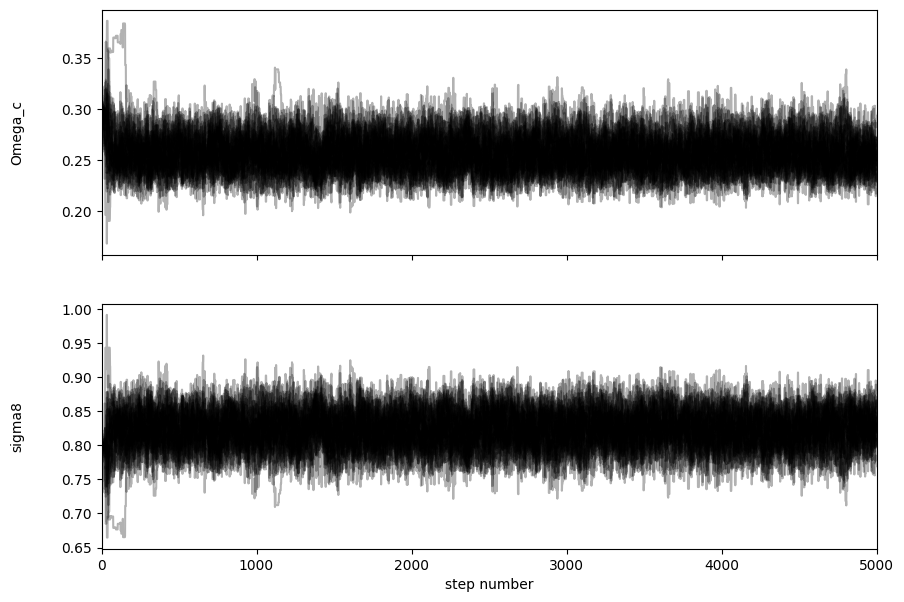

In [80]:
fig, axes = plt.subplots(2, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["Omega_c", "sigma8"]
for i in range(n_dim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [81]:
tau = sampler.get_autocorr_time()
print(tau)

[45.81857181 45.29173357]


In [83]:
reference_samples = sampler.get_chain(discard=1000, thin=25, flat=True)
np.save("reference_samples_ps_jaxcosmo.npy", reference_samples)

In [84]:
reference_samples = np.load("reference_samples_ps_jaxcosmo.npy")

Removed no burn in
Removed no burn in
Removed no burn in


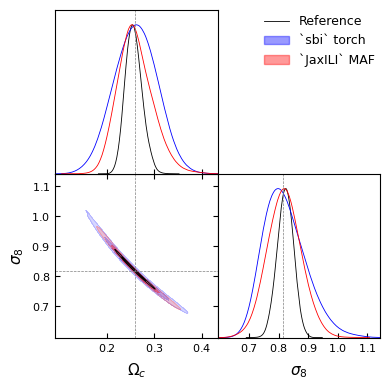

In [85]:
#And have a look at the posterior
labels = [r'\Omega_c', r'\sigma_8']

reference_samples_gd = MCSamples(samples=reference_samples, names=labels, labels=labels)

npe_samples_gd = MCSamples(samples=npe_samples, names=labels,
                                labels=labels)

jaxili_samples_gd = MCSamples(samples=samples_maf_npe, names=labels, labels=labels)

g = plots.get_subplot_plotter()

g.settings.figure_legend_frame = False
g.settings.alpha_filled_add = 0.4

g.triangle_plot([reference_samples_gd, npe_samples_gd, jaxili_samples_gd],
                filled=[False, True],
                legend_labels=["Reference", "`sbi` torch", "`JaxILI` MAF"],
                line_args=[
                    {'color': 'black'},
                    {'color': 'blue'},
                    {'color': 'red'}
                ],
                contour_colors=['black', 'blue', 'red'],
                markers={
                    label: val for label, val in zip(labels, fiducial_params)
                }
               )

plt.show()

In [86]:
npe_S_8 = get_S_8(reference_samples[:, 0], reference_samples[:, 1])
npe_Omega_m = get_Omega_m(reference_samples[:, 0])
reference_samples_S8 = np.column_stack((reference_samples, npe_S_8, npe_Omega_m))

Removed no burn in
Removed no burn in
Removed no burn in


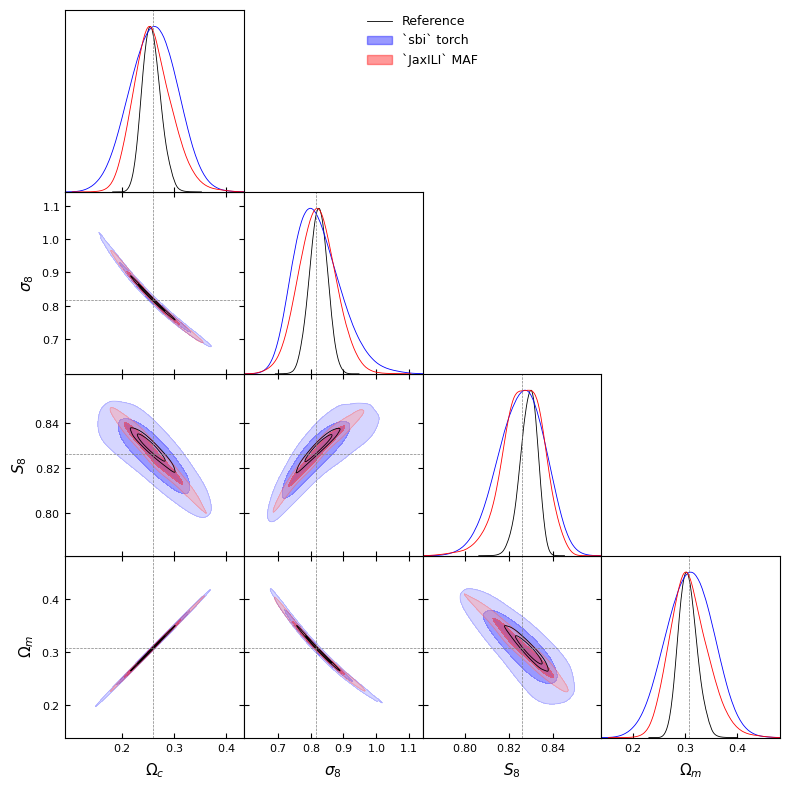

In [87]:
#And have a look at the posterior
labels = [r'\Omega_c', r'\sigma_8', r'S_8', r'\Omega_m']

reference_samples_gd = MCSamples(samples=reference_samples_S8, names=labels, labels=labels)

npe_samples_gd = MCSamples(samples=npe_samples_S8, names=labels,
                                 labels=labels)

jaxili_samples_gd = MCSamples(samples=samples_maf_npe_S8, names=labels, labels=labels)

g = plots.get_subplot_plotter()

g.settings.figure_legend_frame = False
g.settings.alpha_filled_add = 0.4

g.triangle_plot([reference_samples_gd, npe_samples_gd, jaxili_samples_gd],
                filled=[False, True],
                legend_labels=["Reference", "`sbi` torch", "`JaxILI` MAF"],
                line_args=[
                    {'color': 'black'},
                    {'color': 'blue'},
                    {'color': 'red'}
                ],
                contour_colors=['black', 'blue', 'red'],
                markers={
                    label: val for label, val in zip(labels, fiducial_params)
                }
               )

plt.show()